In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import pdb

## Housing Dataset

In [2]:
df=pd.read_csv(r"C:\Users\rutuj\OneDrive\Documents\Northeastern University MS in Data Analytics Engineering\4. Machine Learning\Python Class Lab Sessions\Lab 1 Linear Regression\housing.csv")

In [3]:
df.describe()
df.shape

(505, 14)

In [38]:
class LinearRegression:
    def __init__(self, X,y,learningRate,tolerance,maxIteration,lamda=0.05,batch_size=1,gd=False,reg=False,sgd=False)->None:
        self.X=X
        self.y=y
        self.tolerance=tolerance
        self.learningRate=learningRate
        self.maxIteration=maxIteration
        self.gd=gd
        self.lamda=lamda
        self.reg=reg
        self.sgd=sgd
        self.batch_size=batch_size
    def trainTestSplit(self):
        X_train,X_test,y_train,y_test=train_test_split(self.X,self.y,test_size=0.3,random_state=0)
        return X_train, X_test,y_train,y_test
    
    #Add column of 1 to matrix X (for theta0 )
    def add_X0(self,X):
        return np.column_stack([np.ones([X.shape[0],1]),X]) #1=will add one column
   

    def normalize(self,X):
        mean=np.mean(X,0)
        sd=np.std(X,0)
        X_norm=(X-mean)/sd
        
        X_norm=self.add_X0(X_norm)
        
        return X_norm, mean, sd
    
    def normalizeTestData(self, X, trainMean,trainSd):
        X_norm=(X-trainMean)/trainSd
        X_norm=self.add_X0(X_norm)
        return X_norm
    
    
    def rank(self,X,eps=1e-12):
        u,s,vh=np.linalg.svd(X)
        #u, sigma, v transpose
        return len([x for x in s if abs(x)>eps]) #Number of non zero eigen values
    
    #2 To Solve by closed form , check rank of matrix
    def checkMatrix(self,X):
        X_rank=np.linalg.matrix_rank(X)
        
        if X_rank==min(X.shape[0],X.shape[1]):
            self.fullRank=True
            print("Data is Full Rank")
        else:
            self.fullRank=False
            print("Data is not Full Rank")
            
   #To check number of dimension greater than or less than rows 
    def checkInvertibility(self,X):
        if X.shape[0]<X.shape[1]:
            self.lowRank=True
            print("Data is low Rank")
        else:
            self.lowRank=False
            print("Data is not low Rank")
    
    def closedFormSolution(self,X,y,reg):
        if reg==False:
            w=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)   
        else:
            #self.lamda=0.0001
            w=np.linalg.inv(X.T.dot(X)+ self.lamda*(np.identity(X.shape[1]))).dot(X.T).dot(y)
        return w    
    
    def gradientDescent(self,X,y,reg):
        errorSequences=[]
        last=float('inf')                           # set initial error: infinite
        for t in tqdm(range(self.maxIteration)):             #tqdm tracks a progress bar
            self.w=self.w-self.learningRate *self.costDerivative(X,y)
            cur=self.sse(X,y)
            #print("Cur error: ",str(cur))
            diff=last-cur              #diff should not change when you stop
            #print("Diff error: ",str(diff))
            last=cur
            errorSequences.append(cur)
            if abs(diff)< self.tolerance:
                print("The model stopped -no further improvement")
                break
        self.plot(errorSequences)
    def stochasticGradientDescent(self,X,y):
        errorSequences=[]
        last=float('inf')                           # set initial error: infinite
        sigma=0.0000001
        tao=0.01
        cur=0
        diff=0
        for t in tqdm(range(self.maxIteration)):             #tqdm tracks a progress bar
            
            
            #index=[np.random.randint(1,X.shape[0]-1) for a in np.arange(1,100,1)]
            #X=X[index]
            #y=y[index]
            #print(t)
            #alpha=sigma/(t+tao)
            
            for i in range(0,X.shape[0],self.batch_size):
                Xk=X[i:i+self.batch_size,:]
                yk=y[i:i+self.batch_size]
                self.w=self.w - (self.learningRate* self.costDerivative(X,y))
            
            cur=self.sse(X,y)
            #print("last error:", str(last))
            #print("Cur error: ",str(cur))
            diff=last-cur              #diff should not change when you stop
            #print("Diff error: ",str(diff))
            last=cur

            errorSequences.append(cur)

            if diff< self.tolerance:
                print("The model stopped -no further improvement")
                self.plot(errorSequences)
                break
        self.plot(errorSequences)
    def plot(self,errorSequences):
        plt.ticklabel_format(style='plain')
        
        plt.plot(errorSequences)
        plt.xlabel('Number of Iterations')
        plt.ylabel('Sum of Squared Error')
            
    #def sgd_predict():
        
    
   # def sgd_costDerivative(self,X,y):
    #    y_hat=self.predict(X)
     #   return (y_hat-y)*X
    
    #Cost function   
    def sse(self,X,y):
        y_hat=self.predict(X)
        return ((y_hat-y)**2).sum()
    
    #Predict Function
    
    def predict(self,X):
        return X.dot(self.w) #w is theta
    
    def costFunction(self,X):
        return self.rmse(X,y)/2
    
    def rmse(self,X,y):
        y_hat=self.predict(X)
        return np.sqrt((((y_hat-y)**2)/X.shape[0]).sum())
    
    #0703
    def costDerivative(self,X,y):
        y_hat=self.predict(X)
        if self.reg==False:
            return (y_hat-y).dot(X)
        else:
            #print("Adding lambda")
            return (y_hat-y).dot(X)+(self.lamda * self.w)
        
    #You need to mention here, whether to solve it by closed form or gradient descent
    def fit(self):
        
        self.X_train,self.X_test,self.y_train,self.y_test=self.trainTestSplit()
        self.X_train,self.mean,self.sd=self.normalize(self.X_train)
        self.X_test=self.normalizeTestData(self.X_test, self.mean, self.sd)
        
        self.checkMatrix(self.X_train)
        self.checkInvertibility(self.X_train)
        
        if self.fullRank and not self.lowRank and not self.gd and not self.sgd:
            print("Solving using closed form solution")
            self.w=self.closedFormSolution(self.X_train,self.y_train,self.reg)
            
        elif self.gd and not self.sgd:
            print("Solving using gradient descent")
            self.w=np.ones(self.X_train.shape[1],dtype=np.float64)*0
            self.gradientDescent(self.X_train,self.y_train,self.reg)
        else:
            print("Solving using stochastic gradient descent")
            self.w=np.ones(self.X_train.shape[1],dtype=np.float64)*0
            self.stochasticGradientDescent(self.X_train,self.y_train)
        print()
        print("Weights: "+str(self.w))
        print("Errors in train dataset:")
        print()
        print("RMSE: "+str(self.rmse(self.X_train,self.y_train)))
        print("SSE: "+str(self.sse(self.X_train,self.y_train)))
        print()
        print("Errors in test dataset:")
        print("RMSE: "+str(self.rmse(self.X_test,self.y_test)))
        print("SSE: "+str(self.sse(self.X_test,self.y_test)))
        
        
        

Closed Form Solution Without Regularization

In [39]:
regression=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,gd=False,reg=False,sgd=False)

In [40]:
regression.fit()#Closed Form Solution

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [22.93399433 -0.90751811  1.04796575  0.38867104  0.6622465  -2.17214484
  2.58716716  0.50645061 -2.59559964  2.30818886 -1.67320027 -2.33651383
  0.65618617 -3.99472177]
Errors in train dataset:

RMSE: 4.731796522403048
SSE: 7903.63411028723

Errors in test dataset:
RMSE: 4.624025082730343
SSE: 3250.0044107893414


Closed Form Solution With Regularization

In [41]:
regression=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,lamda=0.05,gd=False,reg=True,sgd=False)

In [42]:
regression.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [22.93074635 -0.90704836  1.04703889  0.38702146  0.6624847  -2.1699506
  2.58783236  0.50540804 -2.59424036  2.30370477 -1.66923307 -2.33589141
  0.65613963 -3.99356316]
Errors in train dataset:

RMSE: 4.731798116592567
SSE: 7903.639435914703

Errors in test dataset:
RMSE: 4.623984873668432
SSE: 3249.9478890109986


Gradient Descent Solution without Regularization

In [43]:
regression1=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,gd=True,reg=False,sgd=False)


Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 356/50000 [00:00<00:02, 21023.49it/s]

The model stopped -no further improvement

Weights: [22.93399433 -0.90293476  1.03869262  0.36249203  0.66589525 -2.16437442
  2.59214504  0.49773684 -2.59871216  2.24055986 -1.59781715 -2.33365665
  0.65569719 -3.99179609]
Errors in train dataset:

RMSE: 4.731875211402964
SSE: 7903.896984750313

Errors in test dataset:
RMSE: 4.6253969322012605
SSE: 3251.9331106233585


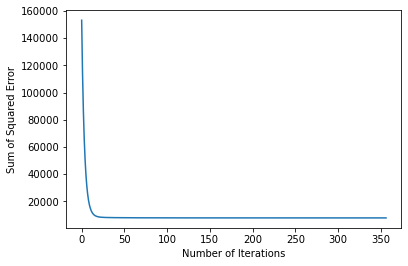

In [44]:
regression1.fit() #Gradient Descent Solution

Gradient Descent Solution with Regularization

In [45]:
regression2=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,lamda=0.05,gd=True,reg=True,sgd=False)


Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 359/50000 [00:00<00:02, 17142.41it/s]

The model stopped -no further improvement

Weights: [22.93074635 -0.90263531  1.03810827  0.3618095   0.6659988  -2.1624825
  2.59262225  0.49702347 -2.59724226  2.23857228 -1.59662445 -2.33314421
  0.65566852 -3.99074905]
Errors in train dataset:

RMSE: 4.731880395303458
SSE: 7903.914302636393

Errors in test dataset:
RMSE: 4.625311586518929
SSE: 3251.813105402711


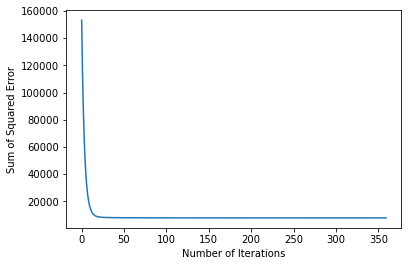

In [46]:
regression2.fit()

Stochastic Gradient Descent without Regularization

In [47]:
regression2=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,lamda=0.05,gd=False,reg=False,sgd=True)

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 2/50000 [00:00<13:42, 60.76it/s]

The model stopped -no further improvement

Weights: [22.93399433 -0.90751187  1.04795304  0.38863521  0.6622515  -2.17213471
  2.58717384  0.50643895 -2.59560401  2.30809621 -1.67309671 -2.33651008
  0.6561855  -3.99471789]
Errors in train dataset:

RMSE: 4.731796522550967
SSE: 7903.634110781373

Errors in test dataset:
RMSE: 4.624026910717234
SSE: 3250.0069803976485


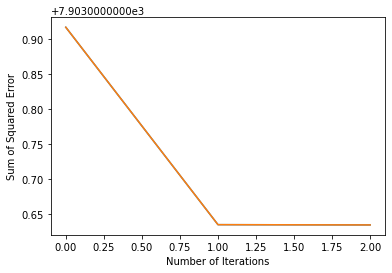

In [48]:
regression2.fit() #Stochastic Gradient Descent

Stochastic Gradient Descent With Regularization

In [49]:
regression2=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,lamda=0.05,gd=False,reg=True,sgd=True)

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 2/50000 [00:00<17:27, 47.74it/s]

The model stopped -no further improvement

Weights: [22.93074635 -0.90704226  1.04702648  0.38698647  0.66248958 -2.16994072
  2.58783888  0.50539665 -2.59424463  2.30361427 -1.66913192 -2.33588774
  0.65613897 -3.99355938]
Errors in train dataset:

RMSE: 4.731798129591283
SSE: 7903.639479338856

Errors in test dataset:
RMSE: 4.623986668629091
SSE: 3249.950412172254


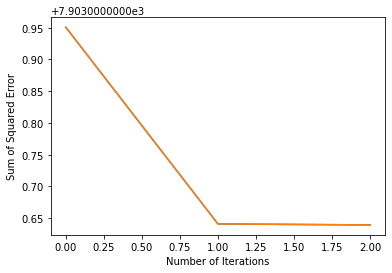

In [50]:
regression2.fit() #Stochastic Gradient Descent

## Yacht Dataset 

In [51]:
df=pd.read_csv(r"C:\Users\rutuj\OneDrive\Documents\Northeastern University MS in Data Analytics Engineering\4. Machine Learning\Python Class Lab Sessions\Lab 1 Linear Regression\yachtData.csv")

In [52]:
df.head()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


In [53]:
df.shape

(307, 7)

Closed form Without Regularization

In [54]:
regression=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,gd=False,reg=False,sgd=False)

In [55]:
regression.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [10.74271028  0.54271589 -0.48644592  0.53145418 -0.58852203 -0.84401335
 12.89451446]
Errors in train dataset:

RMSE: 8.83244987355699
SSE: 16694.604544543938

Errors in test dataset:
RMSE: 9.051378846467498
SSE: 7619.253689071977


Closed form With Regularization

Here, it can be seen that without regularization, the error in training data set is less compared to that in test data set.(which means Overfitting). By applying regularization of lambda=5, we can reduce the test data set error and hence reduce overfitting

In [56]:
regression_1_yacht=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,lamda=5,gd=False,reg=True,sgd=False)

In [57]:
regression_1_yacht.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [ 1.04974429e+01  5.34012758e-01 -6.00489883e-01  8.80980900e-03
 -1.62173941e-01 -3.38768802e-01  1.25970881e+01]
Errors in train dataset:

RMSE: 8.841046171095709
SSE: 16727.11684348146

Errors in test dataset:
RMSE: 8.965078933115244
SSE: 7474.655545759771


Gradient Descent Solution without Regularization

In [58]:
regression_2_yacht=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,gd=True,reg=False,sgd=False)

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 558/50000 [00:00<00:01, 25431.35it/s]

The model stopped -no further improvement

Weights: [10.74271028  0.54013899 -0.561333    0.23019536 -0.34306019 -0.55487531
 12.89266347]
Errors in train dataset:

RMSE: 8.832541346001031
SSE: 16694.95033856699

Errors in test dataset:
RMSE: 9.052068542976757
SSE: 7620.414876327689


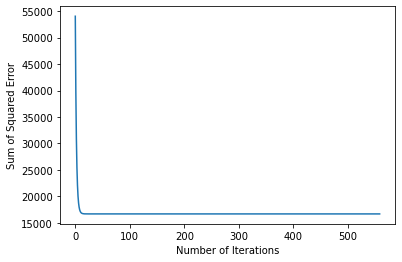

In [59]:
regression_2_yacht.fit()

Gradient Descent Solution with Regularization

In [60]:
regression_2_yacht=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,lamda=10,gd=True,reg=True,sgd=False)

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  0%|          | 131/50000 [00:00<00:02, 21893.21it/s]

The model stopped -no further improvement

Weights: [10.263125    0.52890271 -0.60620791 -0.07489317 -0.09339158 -0.25487309
 12.31549818]
Errors in train dataset:

RMSE: 8.864592068247488
SSE: 16816.332402797365

Errors in test dataset:
RMSE: 8.896537053329496
SSE: 7360.798553337615


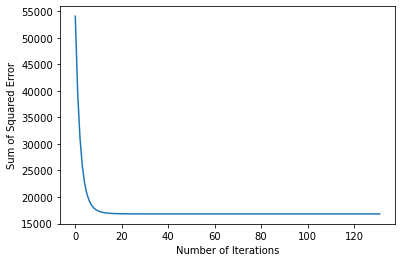

In [61]:
regression_2_yacht.fit()

Stochastic Gradient Descent Solution without Regularization

In [62]:
regression_3_yacht=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,gd=False,reg=False,sgd=True)

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 11/50000 [00:00<03:51, 216.25it/s]

The model stopped -no further improvement

Weights: [10.74271028  0.54257323 -0.49059154  0.51477699 -0.57493367 -0.82800715
 12.89441199]
Errors in train dataset:

RMSE: 8.832450153879812
SSE: 16694.60560424511

Errors in test dataset:
RMSE: 9.051410529840105
SSE: 7619.307029912133


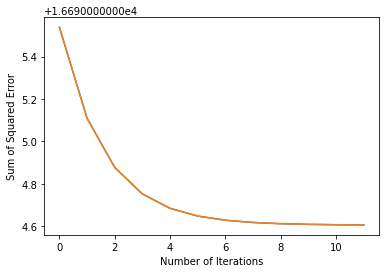

In [63]:
regression_3_yacht.fit()

In [64]:
regression_3_yacht=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,lamda=1,gd=False,reg=True,sgd=True)

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 12/50000 [00:00<04:42, 176.86it/s]

The model stopped -no further improvement

Weights: [10.69274419  0.53951811 -0.55196179  0.25485663 -0.36305986 -0.57781324
 12.83287675]
Errors in train dataset:

RMSE: 8.832872525717523
SSE: 16696.202329893145

Errors in test dataset:
RMSE: 9.032851848527173
SSE: 7588.094364121995


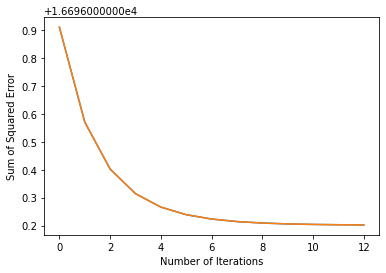

In [65]:
regression_3_yacht.fit()

## Concrete Dataset

In [66]:
df=pd.read_csv(r"C:\Users\rutuj\OneDrive\Documents\Northeastern University MS in Data Analytics Engineering\4. Machine Learning\Python Class Lab Sessions\Lab 1 Linear Regression\concreteData.csv")

In [67]:
df.head()

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


In [68]:
df.shape

(1029, 9)

Closed Form Without Regularization

In [69]:
regression_1_conrete=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,gd=False,reg=False,sgd=False)

In [70]:
regression_1_conrete.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [35.55869444 13.07061719  9.29612788  6.07754028 -2.38797659  2.13444427
  1.74782814  1.75752107  7.36636378]
Errors in train dataset:

RMSE: 10.041854635012676
SSE: 72603.96804772239

Errors in test dataset:
RMSE: 11.106342967100199
SSE: 38115.41391778253


Closed Form With Regularization

In [71]:
regression_1_conrete=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,lamda=5,gd=False,reg=True,sgd=False)

In [72]:
regression_1_conrete.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [35.31346207 11.93611046  8.15994274  5.07161968 -3.12597866  2.14843617
  0.98630262  0.76779464  7.26713929]
Errors in train dataset:

RMSE: 10.05445696636325
SSE: 72786.31551968434

Errors in test dataset:
RMSE: 11.096146519828066
SSE: 38045.46048515319


Gradient Descent Solution without Regularization

In [73]:
regression_2_conrete=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,gd=True,reg=False,sgd=False)

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 443/50000 [00:00<00:03, 16452.33it/s]

The model stopped -no further improvement

Weights: [35.55869444 13.06540412  9.29085934  6.07298081 -2.39238759  2.13389392
  1.74374962  1.75244069  7.36620932]
Errors in train dataset:

RMSE: 10.041854848466567
SSE: 72603.97113432348

Errors in test dataset:
RMSE: 11.106279311277474
SSE: 38114.97700329399


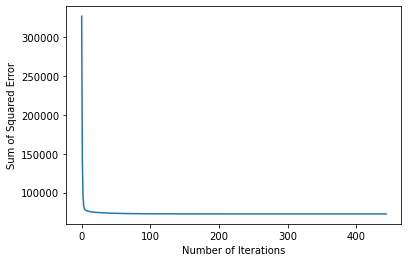

In [74]:
regression_2_conrete.fit()

Gradient Descent Solution with Regularization

In [75]:
regression_2_conrete=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,lamda=10,gd=True,reg=True,sgd=False)

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 559/50000 [00:00<00:02, 23353.68it/s]

The model stopped -no further improvement

Weights: [35.07158904 11.1311055   7.35680075  4.35647911 -3.59797833  2.18586962
  0.47508292  0.09408741  7.17942276]
Errors in train dataset:

RMSE: 10.081936489092215
SSE: 73184.7192264641

Errors in test dataset:
RMSE: 11.102386609617483
SSE: 38088.2634246888


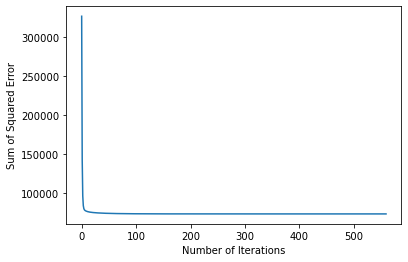

In [76]:
regression_2_conrete.fit()

Stochastic Gradient Descent Without Regularization

In [79]:
regression_3_conrete=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0000001, maxIteration=50000,gd=False,reg=False,sgd=True)

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 2/50000 [00:00<30:45, 27.10it/s]

The model stopped -no further improvement

Weights: [35.55869444 13.07061719  9.29612788  6.07754028 -2.38797659  2.13444427
  1.74782814  1.75752107  7.36636378]
Errors in train dataset:

RMSE: 10.041854635012676
SSE: 72603.96804772239

Errors in test dataset:
RMSE: 11.106342967100199
SSE: 38115.41391778252


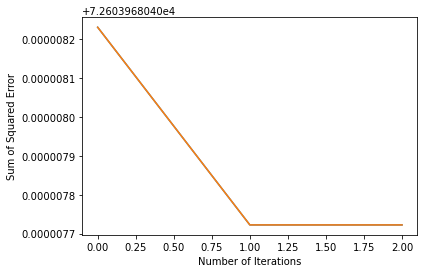

In [78]:
regression_3_conrete.fit()

Stochastic Gradient Solution with Regularization

In [80]:
regression_3_conrete=LinearRegression(df.values[:,0:-1],df.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,lamda=10,gd=False,reg=True,sgd=True)

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 2/50000 [00:00<34:54, 23.87it/s]

The model stopped -no further improvement

Weights: [35.07158904 11.13111611  7.35681148  4.35648839 -3.59796935  2.18587074
  0.47509122  0.09409775  7.17942308]
Errors in train dataset:

RMSE: 10.081936193307401
SSE: 73184.71493226365

Errors in test dataset:
RMSE: 11.102386511171705
SSE: 38088.26274922525


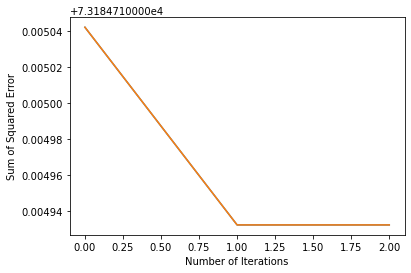

In [81]:
regression_3_conrete.fit()

Observation:

## Effect of Learning Rate (alpha)
If Learning Rate (alpha) is too large:
It will miss the minima and continously keep on re-calculating the weights for more than 50,000 iterations in attempt to reach minima.

If Learning Rate (alpha) is too low:
The model will take more number of iterations to reach to the minima

## Effect of Regulariztion Parameter (lambda)
As value of lamda increases, some of the values of weights start tending to 0

If Regularization Parameter (lamda) is too large (e.g.: 1000):
Then overfitting will occur. i.e. Training error as well as tesing error will be high as compared to equivalent model without regularization

If Regularization Parameter (lamda) is too large (e.g.: 0.00001):
There will be no/very little effect of lambda on the model. So the model will be similar to the one without regularization. Without regularization, if the model is Overfitting, then such value of lambda will also tend to overfit.
